In [1]:
from ultralytics import YOLO
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    confusion_matrix)
import seaborn as sns


# Convert YOLO Format to X1Y1, X2Y2

In [2]:
def convert_labels_to_x1y1_x2y2(label_file_content, img_width, img_height, class_names):
    # assumption is class id is in chronological order starting from 0
    # and it has corresponding class name based on the class id
    # boxes_dict = {}
    coords_list = []
    for label in label_file_content:
        class_id, x, y, width, height = label

        x_abs = float(x) * img_width
        y_abs = float(y) * img_height

        x1 = x_abs - (float(width) * 0.5) * img_width
        y1 = y_abs - (float(height) * 0.5) * img_height
        x2 = x_abs + (float(width) * 0.5) * img_width
        y2 = y_abs + (float(height) * 0.5) * img_height
        # boxes_dict[class_name] = {'x1': x1,
        #                           'y1': y1,
        #                           'x2': x2,
        #                           'y2': y2}
        coords = [x1, y1, x2, y2]
        coords_w_label = [class_names[int(class_id)]] + [int(coord) for coord in coords]
        coords_list.append(coords_w_label)
    return coords_list

# Get Label File Content

In [3]:
def get_label_file_content(label_filepath):
    content = []

    with open(label_filepath, "r") as file:
        for line in file:
            row = line.split()
            content.append(row)

    return content

In [4]:
# Get Unformatted Annotated Labels
def get_actual_boxes(filename, class_names):
    frame = filename.split('.')[0]
    label_filepath = f'../performance_test_samples/obj_train_data/{frame}.txt'

    # Read Image
    test_image = f'../performance_test_samples/test_images/{filename}'
    image = cv.imread(test_image)

    height, width, _ = image.shape
    content = get_label_file_content(label_filepath)
    actual_boxes = convert_labels_to_x1y1_x2y2(content, width, height, class_names)
    
    return actual_boxes


# For Plotting Only
# for coord in actual_boxes:
#     label = coord[0]
#     x1 = coord[1]
#     y1 = coord[2]
#     x2 = coord[3]
#     y2 = coord[4]
#     print(label, x1, y1, x2, y2)
#     cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
#     cv.putText(image, label, (x1, y1 + 20), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)

# plt.imshow(image)
# plt.axis('off')
# plt.show

# Plot the Actual and Predicted Boxes in an image

### CNN MODEL

In [5]:
def cnn_classify_obj(img_array):
    model = tf.keras.models.load_model('decoupled_cnn/best_model.h5')
    model.summary()
    brand = model.predict(img_array)
    return brand


# model = tf.keras.models.load_model('decoupled_cnn/my_model.h5')
# model.summary()
# brand = model.predict(img_array)


### YOLO MODEL

In [6]:
def yolo_classify_obj(img_array):
    classifier = YOLO('best_brd.pt')
    predicted_class = classifier.predict(source=img_array)
    predicted_class_number = predicted_class[0].probs.top1
    predicted_class_name = predicted_class[0].names[predicted_class_number]
    return predicted_class_name



In [7]:
def get_predicted_boxes(filename):
    
    predicted_boxes = []
    test_image = f'../performance_test_samples/test_images/{filename}'
    image = cv.imread(test_image)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    img_size = (256,256)
    model = YOLO('yolov8n.pt')
    detected_obj = model.predict(image, conf=0.7, save=False, classes = [39])

    classes = ['coke', 'mountain_dew', 'other', 'pocari']

    if len(detected_obj) != 0:
                for obj in detected_obj:
                    for deets in obj.boxes.data.tolist():
                        xmin, ymin, xmax, ymax = int(deets[0]), int(deets[1]), int(deets[2]), int(deets[3])
                        names = model.names

                        # print(xmin, ymin, xmax, ymax)
                        roi = image[ymin:ymax, xmin:xmax]
                        roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
                        roi = cv.resize(roi, img_size)
                        roi = np.expand_dims(roi, axis=0)
                        # print(roi.shape)

                        probabilities = cnn_classify_obj(roi)
                        # print(probabilities)
                        brand_index = np.argmax(probabilities[0])
                        brand_name = classes[brand_index] 
                        predicted = [brand_name, xmin, ymin, xmax, ymax]
                        predicted_boxes.append(predicted)
                #         print(probabilities)
                #         print(brand_index, brand_name)
                #         cv.rectangle(image, (xmin, ymin) , (xmax, ymax), (0,255,0), 2)
                #         cv.putText(image, brand_name, (xmin, ymin +15), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
                        
                # plt.imshow(image)
                # plt.axis('off')
                # plt.show
    return predicted_boxes

# Calculate IOU

In [8]:
def calculate_iou(actual_box, predicted_box):
    # the dictionary for actual and predicted is for only one box compose of x1, y1, x2, y2
    actual_x1 = int(actual_box[1])
    actual_y1 = int(actual_box[2])
    actual_x2 = int(actual_box[3])
    actual_y2 = int(actual_box[4])

    predicted_x1 = int(predicted_box[1])
    predicted_y1 = int(predicted_box[2])
    predicted_x2 = int(predicted_box[3])
    predicted_y2 = int(predicted_box[4])

    # Calculate the area of the actual bounding box
    actual_area = (actual_x2 - actual_x1) * (actual_y2 - actual_y1)

    # Calculate the area of the predicted bounding box
    predicted_area = (predicted_x2 - predicted_x1) * (predicted_y2 - predicted_y1)

    # Calculate the coordinates of the intersection rectangle
    intersection_x1 = max(actual_x1, predicted_x1)
    intersection_y1 = max(actual_y1, predicted_y1)
    intersection_x2 = min(actual_x2, predicted_x2)
    intersection_y2 = min(actual_y2, predicted_y2)

    # Calculate the area of the intersection rectangle
    intersection_area = max(0, intersection_x2 - intersection_x1) * max(0, intersection_y2 - intersection_y1)

    # Calculate the area of the union
    union_area = actual_area + predicted_area - intersection_area

    # Calculate the IoU
    iou = intersection_area / union_area

    return iou

In [9]:
def sort_predictions(actual_boxes, predicted_boxes):
    correct_detections = []
    false_negatives = []
    correct_detections_index = []
    for i in range(len(actual_boxes)):
        iou_list = []
        for j in range(len(predicted_boxes)):
            iou = calculate_iou(actual_boxes[i], predicted_boxes[j])
            iou_list.append(iou)
        iou_final = max(iou_list)
        # print(iou_list)
        if iou_final > 0.7:
            # correct_item = predicted_boxes[iou_list.index(iou_final)]
            # correct_detections.append(correct_item)
            correct_detections_index.append(iou_list.index(iou_final))
        else:
            false_negatives.append(actual_boxes[i])

    false_positives_index = [index for index in range(len(predicted_boxes)) if index not in correct_detections_index]
    # false_positives = [item for item in correct_detections]
    false_positives = [predicted_boxes[i] for i in false_positives_index]
    correct_detections = [predicted_boxes[i] for i in correct_detections_index]
    
    return correct_detections, false_negatives, false_positives


# Compute for IOU for a Test dataset (Multiple Images)

In [10]:
import os

# Get Class Names
class_names = []
with open('../performance_test_samples/obj.names') as f:
    for line in f:
        class_names.append(line.strip())
    
image_list = os.listdir(r'../performance_test_samples/test_images')
image_list = [item for item in image_list if not item.endswith('.DS_Store')]

X_cnn = []
X_yolo = []
y = []
y_pred_cnn = []
y_pred_yolo = []

detection_true = np.empty(0)
detection_pred = np.empty(0)

for image in image_list:
    actual = []
    predicted = []
    actual = get_actual_boxes(image, class_names)
    predicted = get_predicted_boxes(image)
    
    print(actual)
    print(predicted)
    print("Actual Annotated: ", len(actual))
    print("PRedicted Bottles: ", len(predicted))
    true_positives, false_negatives, false_positives = sort_predictions(actual, predicted)
    # print(true_positives)
    # print(false_negatives)
    # print(false_positives)

    image = f'../performance_test_samples/test_images/{image}'
    test_image = cv.imread(image)
    # test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)

    true_positives, false_negatives, false_positives = sort_predictions(actual, predicted)
    # print(true_positives)
    # print(false_negatives)
    # print(false_positives)

    # Handle Truth Table
    actual_array = np.ones(len(actual))
    # Handle True Positives
    pred_array = np.ones(len(true_positives))
    # Handle False Negatives
    pred_array = np.append(pred_array, np.zeros(len(false_negatives)))
    # Handle False Positives in Pred Array
    pred_array = np.append(pred_array, np.ones(len(false_positives)))
    # Handle False Positives in Actual Array
    actual_array = np.append(actual_array, np.zeros(len(false_positives)))

    detection_pred = np.append(detection_pred, pred_array)
    detection_true = np.append(detection_true, actual_array)

    classes = ['coke', 'mountain_dew', 'other', 'pocari']

    for bottle in actual:
        xmin = bottle[1]
        ymin = bottle[2]
        xmax = bottle[3]
        ymax = bottle[4]
        label = bottle[0]

        roi = test_image[ymin:ymax, xmin:xmax]
        roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
        roi = cv.resize(roi, (256, 256))
        roi = np.expand_dims(roi, axis=0)
        # print(roi.shape)
        X_cnn.append(roi)
        y.append(classes.index(label))

    for bottle in false_positives:
        xmin = bottle[1]
        ymin = bottle[2]
        xmax = bottle[3]
        ymax = bottle[4]
        label = 'other'

        roi = test_image[ymin:ymax, xmin:xmax]
        roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
        roi = cv.resize(roi, (256, 256))
        roi = np.expand_dims(roi, axis=0)
        # print(roi.shape)
        X_cnn.append(roi)
        y.append(classes.index(label))

    for bottle in actual:
        xmin = bottle[1]
        ymin = bottle[2]
        xmax = bottle[3]
        ymax = bottle[4]

        roi = test_image[ymin:ymax, xmin:xmax]
        # roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
        # roi = cv.resize(roi, (256, 256))
        # roi = np.expand_dims(roi, axis=0)
        # print(roi.shape)
        X_yolo.append(roi)

    for bottle in false_positives:
        xmin = bottle[1]
        ymin = bottle[2]
        xmax = bottle[3]
        ymax = bottle[4]

        roi = test_image[ymin:ymax, xmin:xmax]
        # roi = cv.cvtColor(roi, cv.COLOR_BGR2GRAY)
        # roi = cv.resize(roi, (256, 256))
        # roi = np.expand_dims(roi, axis=0)
        # print(roi.shape)
        X_yolo.append(roi)

# CNN Classifier
for image in X_cnn:
    probabilities = cnn_classify_obj(image)
    # print(probabilities)
    brand_index = np.argmax(probabilities[0])
    # brand_name = classes[brand_index]
    y_pred_cnn.append(brand_index)

# YOLO Classifier
for image in X_yolo:
    brand = yolo_classify_obj(image)
    # print(probabilities)
    brand_index = classes.index(brand)
    # brand_name = classes[brand_index]
    y_pred_yolo.append(brand_index)


# X = np.array(X)
y = np.array(y)
y_pred_cnn = np.array(y_pred_cnn)
y_pred_yolo = np.array(y_pred_yolo)


print(y)
print(y_pred_cnn)
print(y_pred_yolo)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
0: 384x640 5 bottles, 305.1ms
Speed: 8.6ms preprocess, 305.1ms inference, 34.3ms postprocess per image at shape (1, 3, 384, 640)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      


0: 384x640 5 bottles, 112.8ms
Speed: 2.7ms preprocess, 112.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      


0: 384x640 6 bottles, 126.1ms
Speed: 2.4ms preprocess, 126.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      


0: 384x640 5 bottles, 110.2ms
Speed: 2.3ms preprocess, 110.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      


0: 384x640 6 bottles, 107.8ms
Speed: 2.8ms preprocess, 107.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      


0: 384x640 6 bottles, 117.1ms
Speed: 1.9ms preprocess, 117.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 126, 126, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 63, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 64)      


0: 384x640 4 bottles, 109.8ms
Speed: 2.0ms preprocess, 109.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


KeyboardInterrupt: 

# Show all cropped images in X

In [ ]:
# for image in X:
#     # Reshape the image to (256, 256) assuming it's grayscale
#     image = np.squeeze(image)  # Remove the single-channel dimension
#     plt.figure()
#     plt.imshow(image, cmap='gray')  # Specify 'gray' colormap for grayscale images
#     plt.axis('off')  # Optional: Hide axis labels and ticks
#     plt.show()

# Confusion Matrix of Object Detection
- False Negatives are objects not detected by YOLO
- False Positives are objects detected by YOLO, but are not real bottles or not annotated

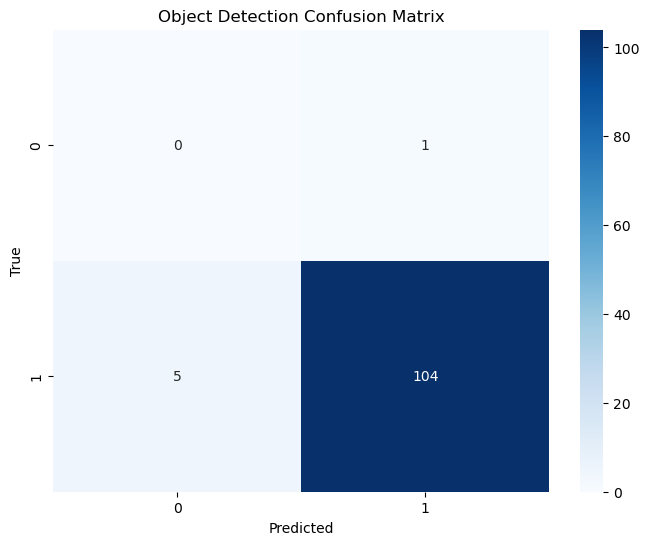

In [ ]:
detection_matrix_raw = confusion_matrix(detection_true, detection_pred)
# bagging_class_sum = np.sum(bagging_matrix_raw[0])
# bagging_conf_percent = (bagging_matrix_raw / bagging_class_sum)
plt.figure(figsize=(8, 6))

sns.heatmap(detection_matrix_raw, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Object Detection Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
detection_rep = classification_report(detection_true, detection_pred)
print("Classification Report (CNN):\n", detection_rep)

# Classification F1 Score
precision = precision_score(detection_true, detection_pred, average='weighted')
print(f"Recall: {precision:.2f}")

# Recall is TP/TP+FalseNeg (Penalizes Higher False Negatives)

Classification Report (CNN):
               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         1
         1.0       0.99      0.95      0.97       109

    accuracy                           0.95       110
   macro avg       0.50      0.48      0.49       110
weighted avg       0.98      0.95      0.96       110

Recall: 0.98


# Confusion Matrix of Classification

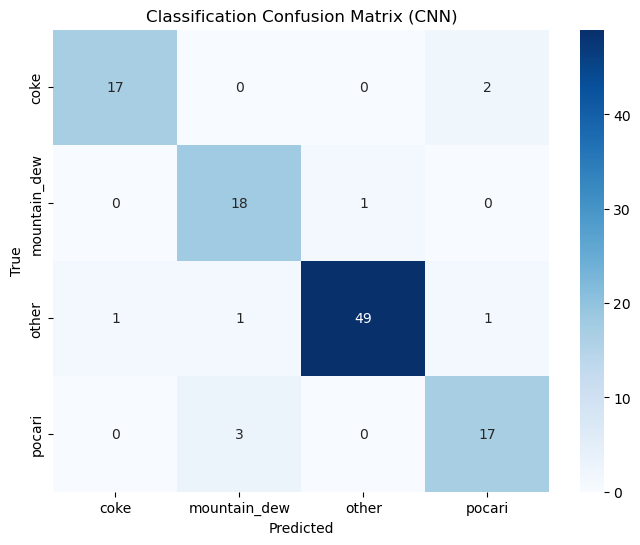

In [ ]:
classification_matrix_raw = confusion_matrix(y, y_pred_cnn)
# bagging_class_sum = np.sum(bagging_matrix_raw[0])
# bagging_conf_percent = (bagging_matrix_raw / bagging_class_sum)
plt.figure(figsize=(8, 6))

sns.heatmap(classification_matrix_raw, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Classification Confusion Matrix (CNN)')
plt.show()

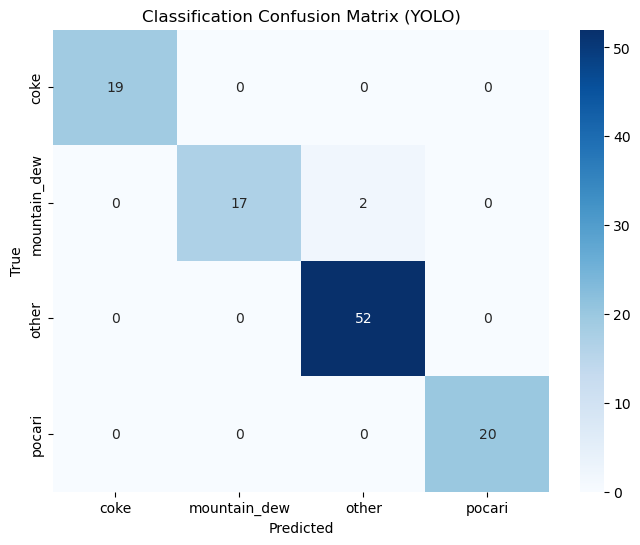

In [ ]:
classification_matrix_raw = confusion_matrix(y, y_pred_yolo)
# bagging_class_sum = np.sum(bagging_matrix_raw[0])
# bagging_conf_percent = (bagging_matrix_raw / bagging_class_sum)
plt.figure(figsize=(8, 6))

sns.heatmap(classification_matrix_raw, annot=True, cmap='Blues', fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Classification Confusion Matrix (YOLO)')
plt.show()

# Classification Report, F1 Score

In [ ]:
# Classification Report
classification_rep = classification_report(y, y_pred_cnn, target_names=classes)
print("Classification Report (CNN):\n", classification_rep)

# Classification F1 Score
f1 = f1_score(y, y_pred_cnn, average='weighted')
print(f"F1 Score: {f1:.2f}")

Classification Report (CNN):
               precision    recall  f1-score   support

        coke       0.94      0.89      0.92        19
mountain_dew       0.82      0.95      0.88        19
       other       0.98      0.94      0.96        52
      pocari       0.85      0.85      0.85        20

    accuracy                           0.92       110
   macro avg       0.90      0.91      0.90       110
weighted avg       0.92      0.92      0.92       110

F1 Score: 0.92


In [ ]:
# Classification Report
classification_rep = classification_report(y, y_pred_yolo, target_names=classes)
print("Classification Report (YOLO):\n", classification_rep)

# Classification F1 Score
f1 = f1_score(y, y_pred_cnn, average='weighted')
print(f"F1 Score: {f1:.2f}")

Classification Report (YOLO):
               precision    recall  f1-score   support

        coke       1.00      1.00      1.00        19
mountain_dew       1.00      0.89      0.94        19
       other       0.96      1.00      0.98        52
      pocari       1.00      1.00      1.00        20

    accuracy                           0.98       110
   macro avg       0.99      0.97      0.98       110
weighted avg       0.98      0.98      0.98       110

F1 Score: 0.92


# Extras

In [ ]:
from ultralytics import YOLO
import cv2
import os 
import pandas as pd

class_names = ['royal', 'kopiko', 'fit_n_right', 'smart_c']
df = pd.DataFrame(columns=['royal_iou', 'kopiko_iou', 'fit_n_right_iou', 'smart_c_iou'])

# Load a pretrained YOLOv8n model
model = YOLO(r'runs\detect\train18\weights\best.pt')

file_path_list = []
file_name_list = os.listdir(r'data2\validation\labels')
for file_name in file_name_list:
    file_path = os.path.join(r'data2\validation\labels', file_name)
    file_path_list.append(file_path)

content_list = []
for file in file_path_list:
    cont = get_label_file_content(file)
    content_list.append(cont)


actual_boxes_dict_list = []
for cont in content_list:
    actual_boxes_dict = convert_labels_to_x1y1_x2y2(cont, 1920, 1080, class_names)
    actual_boxes_dict_list.append(actual_boxes_dict)


# Run inference on an image
results = model(r'data2\validation\images', conf=0.75)  # list of 1 Results object

for id, r in enumerate(results):
    frame_pred_boxes_dict = get_prediction_boxes(r)
    frame_actual_boxes_dict = actual_boxes_dict_list[id]
    df_row = []
    for cl in class_names:
        try:
            iou = calculate_iou(frame_actual_boxes_dict[cl], frame_pred_boxes_dict[cl])
        except KeyError:
            iou = 0
        
        df_row.append(iou)
    
    df.loc[len(df)] =df_row

df.to_csv('iou_data_train18.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'runs\\detect\\train18\\weights\\best.pt'

# Object Count for Model Prediction

In [ ]:
import pandas as pd
import json

def get_prediction_count(model_result):
    pred = model_result[0].tojson()
    result_dict = json.loads(pred)
    df = pd.DataFrame(result_dict)
    products_count = df['name'].value_counts().to_dict()
    return products_count

# Object Count for Label File

In [ ]:
# label_file = [
#     [0, 0.354193, 0.520435, 0.098792, 0.451944],
#     [1, 0.186721, 0.526861, 0.091568, 0.430519],
#     [2, 0.718047, 0.432620, 0.103615, 0.610444],
#     [3, 0.545758, 0.455111, 0.101203, 0.565463]
# ]

# object_count = {}

# for label in label_file:
#     class_id = label[0]
#     if class_id not in object_count:
#         object_count[class_id] = 0
#     object_count[class_id] += 1

# print("Object counts:")
# for class_id, count in object_count.items():
#     print(f"Class {class_id}: {count}")

def get_actual_count(label_file):
    object_count = {}

    for label in label_file:
        class_id = label[0]
        if class_id not in object_count:
            object_count[class_id] = 0
        object_count[class_id] += 1

Object counts:
Class 0: 1
Class 1: 1
Class 2: 1
Class 3: 1


# Get the Count Accuracy of the Model

In [ ]:
def get_model_count_accuracy(actual_count_dict, prediction_count_dict):
    # assume keys are the same for both input dictionaries
    classes = list(actual_count_dict.keys())
    accuracy_dict = {}
    total_actual_object = 0
    total_predicted_object = 0

    for cl in classes:
        accuracy_dict[cl] = prediction_count_dict[cl] / actual_count_dict[cl]
        total_actual_object += actual_count_dict[cl]
        total_predicted_object += prediction_count_dict[cl]
    accuracy_dict['overall'] = total_predicted_object / total_actual_object
    
    return accuracy_dict


# Validation Performance from Docs


In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO(r'runs\detect\train18\weights\best.pt')  # load a custom model

# Validate the model
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map    # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps   # a list contains map50-95 of each category


c:\Users\RETRETA\anaconda3\envs\yolo-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-08 10:57:13,070	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-09-08 10:57:13,605	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
Ultralytics YOLOv8.0.166  Python-3.10.12 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv8n summary (fused): 168 layers, 3006428 parameters, 0 gradients
val: Scanning C:\Users\RETRETA\Documents\Python\AI ML Bootcamp\ai ml\final project\YOLOv8 Object Detection\data2\validation\labels.cache... 95 images, 0 backgrounds, 0 corrupt: 100%|██████████| 95/95 [00:00<?, ?it/s]
    

array([    0.87612,     0.86708,     0.86112,     0.88872])